# SOLUTIONS: Analysis and Classification with Natural Language [Amazon Reviews Version]

In this notebook we will continue with the data we prepared in the last lecture.  Our goals will be to separate the data into high and low Ratings, compare and analyze them to notice any differences, and then to create a model to classify future Ratings as having a high or low sentiment.

In [1]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Loading Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', 300)

# Import Processed Data

We created several versions of our text in the previous lecture.  We will load those again to use for analysis and classification

In [3]:
# ## Load processed data
# # df = pd.read_csv('../Data/processed_data.csv')
# df = pd.read_csv('data/processed/processed-reviews.csv')
# df.head()

In [4]:
# df.isna().sum()

In [5]:
# df.info()

In [6]:

# test_lemmas = df.loc[0,'spacy_lemmas']
# test_lemmas

In [7]:
# ## Check type of first row
# type(test_lemmas)

## Convert strings of lists to lists

You might recall that pandas interprets lists and strings when importing data.  We can define a quick function to convert them back.

How can we use string methods to do this?

In [8]:
# ## Function to convert string lists back to lists

# def convert_to_list(string):
#     """Remove braces, split tokens on commas, and then strip quotes from outside of each token"""
#     new_list = [token.strip("' ") for token in string.strip("[]").split(',')]
#     return new_list

In [9]:
# ## applymap function to convert string lists back to lists.

# cols = ['tokens','no_stops','no_stops_no_punct','spacy_lemmas'] #, 'bigrams']
# df[cols] = df[cols].applymap(convert_to_list)
# df.info()

In [10]:
# type(df.loc[0,'spacy_lemmas'])

Alternatively, the saved joblib file version does not need any additional preprocessing, the lists are still lists.

In [11]:
import joblib
df = joblib.load('data/processed/processed-reviews.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 4362
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   asin               4363 non-null   object 
 1   reviewerID         4363 non-null   object 
 2   overall            4363 non-null   float64
 3   year               4363 non-null   int64  
 4   category           4363 non-null   object 
 5   text-raw           4363 non-null   object 
 6   length             4363 non-null   int64  
 7   text               4363 non-null   object 
 8   lower_text         4363 non-null   object 
 9   tokens             4363 non-null   object 
 10  no_stops           4363 non-null   object 
 11  no_stops_no_punct  4363 non-null   object 
 12  spacy_lemmas       4363 non-null   object 
 13  bigrams            4363 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 511.3+ KB


,asin,reviewerID,overall,year,category,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,B007JINB0W,A1P9BVW2JB1OVL,3.0,2014,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Odd chewy texture: This has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. I can tolerate it, but it isn't really tasty. Surprisingly, my husband enjoyed it more than I did. I just couldn't get past the texture (rubber noodles).",291,"Odd chewy texture: This has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. I can tolerate it, but it isn't really tasty. Surprisingly, my husband enjoyed it more than I did. I just couldn't get past the texture (rubber noodles).","odd chewy texture: this has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. i can tolerate it, but it isn't really tasty. surprisingly, my husband enjoyed it more than i did. i just couldn't get past the texture (rubber noodles).","[odd, chewy, texture, :, this, has, a, odd, chewy, texture, and, not, much, flavor, ,, but, used, as, a, substitute, for, pasta, ,, it, helps, cut, calories, and, carbs, ., i, can, tolerate, it, ,, but, it, is, n't, really, tasty, ., surprisingly, ,, my, husband, enjoyed, it, more, than, i, did,...","[odd, chewy, texture, :, odd, chewy, texture, much, flavor, ,, used, substitute, pasta, ,, helps, cut, calories, carbs, ., tolerate, ,, n't, really, tasty, ., surprisingly, ,, husband, enjoyed, ., could, n't, get, past, texture, (, rubber, noodles, ), .]","[odd, chewy, texture, odd, chewy, texture, much, flavor, used, substitute, pasta, helps, cut, calories, carbs, tolerate, n't, really, tasty, surprisingly, husband, enjoyed, could, n't, get, past, texture, rubber, noodles]","[odd, chewy, texture, odd, chewy, texture, flavor, substitute, pasta, help, cut, calorie, carb, tolerate, tasty, surprisingly, husband, enjoy, past, texture, rubber, noodle]","[(odd, chewy), (chewy, texture), (texture, odd), (odd, chewy), (chewy, texture), (texture, flavor), (flavor, substitute), (substitute, pasta), (pasta, help), (help, cut), (cut, calorie), (calorie, carb), (carb, tolerate), (tolerate, tasty), (tasty, surprisingly), (surprisingly, husband), (husban..."
1,B007JINB0W,A5JZ2DBS9H3F6,1.0,2016,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,77,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,fishy gross: they smell of fish and have a rubbery hard to chew texture. yuck,"[fishy, gross, :, they, smell, of, fish, and, have, a, rubbery, hard, to, chew, texture, ., yuck]","[fishy, gross, :, smell, fish, rubbery, hard, chew, texture, ., yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[(fishy, gross), (gross, smell), (smell, fish), (fish, rubbery), (rubbery, hard), (hard, chew), (chew, texture), (texture, yuck)]"
2,B007JINB0W,A3VYMBAX7IFV3B,1.0,2014,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,One Star: MOM DID NOT LIKE THESE,32,One Star: MOM DID NOT LIKE THESE,one star: mom did not like these,"[one, star, :, mom, did, not, like, these]","[one, star, :, mom, like]","[one, star, mom, like]","[star, mom, like]","[(star, mom), (mom, like)]"
3,B007JINB0W,A25MLB8QXVM2LS,2.0,2018,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol or claim that the online description shows.,289,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine

In [12]:
## Check type of first row
type(df.loc[0, 'spacy_lemmas'])

list

## Creating Groups for Classification

In [13]:
# Checking what values are in the overall ratings
df['overall'].value_counts()

5.0    1868
1.0    1070
4.0     605
3.0     453
2.0     367
Name: overall, dtype: int64

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [14]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None
    

In [15]:
# Should return high
create_groups(5.0)

'high'

In [16]:
# Should return low
create_groups(2)

'low'

In [17]:
# Should return nothing
create_groups(4.9)

In [18]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df['rating'].value_counts(dropna=False)

high    1868
low     1437
None    1058
Name: rating, dtype: int64

In [19]:
# # target_map = {1.0:'low',
# #              2.0:'low',
# #               # 3.0:'mid',
# #               # 4.0:'high',
# #              5.0:'high'}
# df['rating'] = df['overall'].map(create_target)
# df['rating'].value_counts(dropna=False)

# Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [20]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.565204
low     0.434796
Name: rating, dtype: float64

There are more neutral Ratings any any other class, but high and low Ratings are pretty balanced.

# Divide by Group

Since we want to compare and classify high rating reviews vs low-rating reviews, we will create 2 different dataframes: 

In [21]:
## Divide documents by sentiment
high = df.loc[df['rating'] == 'high']
low = df.loc[df['rating'] == 'low']
print('high Ratings')
display(high.head())
print('low Ratings')
display(low.head())

high Ratings


,asin,reviewerID,overall,year,category,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams,rating
7,B007JINB0W,A1KN12F4BTXYAF,5.0,2017,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Great rice alternative for me: Absolutely love it! I first bought the variety pack and the rice is my favorite. The texture of the rice is really good, it absorbs flavor so well, and is super easy and fast to prepare. Excellent option for those sensitive to carbs, looking to add some health to f...",418,"Great rice alternative for me: Absolutely love it! I first bought the variety pack and the rice is my favorite. The texture of the rice is really good, it absorbs flavor so well, and is super easy and fast to prepare. Excellent option for those sensitive to carbs, looking to add some health to f...","great rice alternative for me: absolutely love it! i first bought the variety pack and the rice is my favorite. the texture of the rice is really good, it absorbs flavor so well, and is super easy and fast to prepare. excellent option for those sensitive to carbs, looking to add some health to f...","[great, rice, alternative, for, me, :, absolutely, love, it, !, i, first, bought, the, variety, pack, and, the, rice, is, my, favorite, ., the, texture, of, the, rice, is, really, good, ,, it, absorbs, flavor, so, well, ,, and, is, super, easy, and, fast, to, prepare, ., excellent, option, for, ...","[great, rice, alternative, :, absolutely, love, !, first, bought, variety, pack, rice, favorite, ., texture, rice, really, good, ,, absorbs, flavor, well, ,, super, easy, fast, prepare, ., excellent, option, sensitive, carbs, ,, looking, add, health, family, meals, ,, trying, cut, carbs, ., 's, ...","[great, rice, alternative, absolutely, love, first, bought, variety, pack, rice, favorite, texture, rice, really, good, absorbs, flavor, well, super, easy, fast, prepare, excellent, option, sensitive, carbs, looking, add, health, family, meals, trying, cut, carbs, 's, exactly, rice, great, optio...","[great, rice, alternative, absolutely, love, buy, variety, pack, rice, favorite, texture, rice, good, absorb, flavor, super, easy, fast, prepare, excellent, option, sensitive, carb, look, add, health, family, meal, try, cut, carb, exactly, rice, great, option, crave]","[(great, rice), (rice, alternative), (alternative, absolutely), (absolutely, love), (love, buy), (buy, variety), (variety, pack), (pack, rice), (rice, favorite), (favorite, texture), (texture, rice), (rice, good), (good, absorb), (absorb, flavor), (flavor, super), (super, easy), (easy, fast), (f...",high
9,B007JINB0W,AQZSBXE2QA9C4,5.0,2016,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,I love these noodles-my diabetic husband can eat them and not ...: I love these noodles-my diabetic husband can eat them and not have them raise his blood sugar. I like them because I do not eat wheat. They have a great chewy texture.,234,I love these noodles-my diabetic husband can eat them and not ...: I love these noodles-my diabetic husband can eat them and not have them raise his blood sugar. I like them because I do not eat wheat. They have a great chewy texture.,i love these noodles-my diabetic husband can eat them and not ...: i love these noodles-my diabetic husband can eat them and not have them raise his blood sugar. i like them because i do not eat wheat. they have a great chewy texture.,"[i, love, these, noodles-my, diabetic, husband, can, eat, them, and, not, ..., :, i, love, these, noodles-my, diabetic, husband, can, eat, them, and, not, have, them, raise, his, blood, sugar, ., i, like, them, because, i, do, not, eat, wheat, ., they, have, a, great, chewy, texture, .]","[love, noodles-my, diabetic, husband, eat, ..., :, love, noodles-my, diabetic, husband, eat, raise, blood, sugar, ., like, eat, wheat, ., great, chewy, texture, .]","[love, noodles-my, diabetic, husband, eat, ..., love, noodles-my, diabetic, husband, eat, raise, blood, sugar, like

low Ratings


,asin,reviewerID,overall,year,category,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams,rating
1,B007JINB0W,A5JZ2DBS9H3F6,1.0,2016,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,77,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,fishy gross: they smell of fish and have a rubbery hard to chew texture. yuck,"[fishy, gross, :, they, smell, of, fish, and, have, a, rubbery, hard, to, chew, texture, ., yuck]","[fishy, gross, :, smell, fish, rubbery, hard, chew, texture, ., yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[(fishy, gross), (gross, smell), (smell, fish), (fish, rubbery), (rubbery, hard), (hard, chew), (chew, texture), (texture, yuck)]",low
2,B007JINB0W,A3VYMBAX7IFV3B,1.0,2014,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,One Star: MOM DID NOT LIKE THESE,32,One Star: MOM DID NOT LIKE THESE,one star: mom did not like these,"[one, star, :, mom, did, not, like, these]","[one, star, :, mom, like]","[one, star, mom, like]","[star, mom, like]","[(star, mom), (mom, like)]",low
3,B007JINB0W,A25MLB8QXVM2LS,2.0,2018,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol or claim that the online description shows.,289,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol or claim that the online description shows.,the noodles themselves are fine. the amazon label description claims they are certified ...: the noodles themselves are fine. the amazon label description claims they are certified non gmo and vegan but the actual package contains no such symbol or claim that the online description shows.,"[the, noodles, themselves, are, fine, ., the, amazon, label, description, claims, they, are, certified, ..., :, the, noodles, themselves, are, fine, ., the, amazon, label, description, claims, they, are, certified, non, gmo, and, vegan, but, the, actual, package, contains, no, such, symbol, or, ...","[noodles, fine, ., amazon, label, description, claims, certified, ..., :, noodles, fine, ., amazon, label, description, claims, certified, non, gmo, vegan, actual, package, contains, symbol, claim, online, description, shows, .]","[noodles, fine, amazon, label, description, claims, certified, ..., noodles, fine, amazon, label, description, claims, certified, non, gmo, vegan, actual, package, contains, symbol, claim, online, description, shows]","[noodle, fine, amazon, label, description, claim, certify, noodle, fine, amazon, label, description, claim, certify, non, gmo, vegan, actual, package, contain, symbol, claim, online, description, show]","[(noodle, fine), (fine, amazon), (amazon, label), (label, description), (description, claim), (claim, certify), (certify, noodle), (noodle, fine), (fine, amazon), (amazon, label), (label, description), (description, claim), (claim, certify), (certify, non), (non, gmo), (gmo, vegan), (vegan, actu...",low
5,B007JINB0W,A26RU99Z7SCFP3,2.0,2018,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Two Stars: Not good lol. Like not god at all.,45,Two Stars: Not good lol. Like not god at all.,two stars: not good lol. like not god at all.,"[two, stars, :, not, good, lol, ., like, not, god, at, all, .]","[two, stars, :, good, lol, ., like, god, .]","[two, stars, good, lol, like, god]","[star, good, lol, like, god]","[(star, good), (good, lol), (lol, like), (like, god)]",low
6,B007JINB0W,A1GBV7MGIPNZUO,1.0,20

# Length

One easy way to compare text is to compare the length of each text.  We could compare the number of character or tokens.  In this case we will compare the number of characters in each Rating for each sentiment.

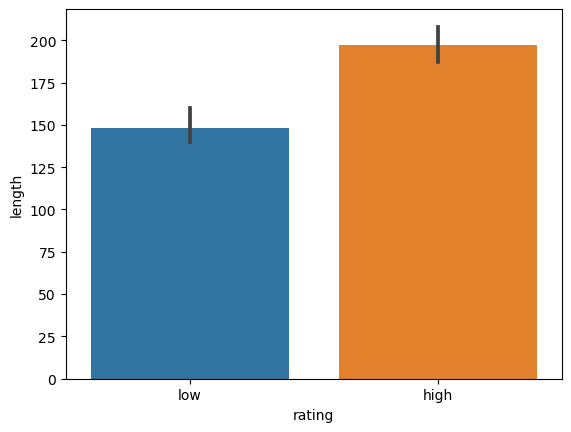

 The median character length for 148.0 for low Ratings and 197.0 for high ratings.


In [22]:
## visualize median review length
high_len = high['length'].median()
low_len = low['length'].median()

ax = sns.barplot(data=df, x='rating', y='length', estimator='median',);

# Show plot before print statement
plt.show()
print(f' The median character length for {low_len} for low Ratings and {high_len} for high ratings.')

# Save figure
fig = ax.get_figure()

In [23]:
# Create a folder for images
import os
os.makedirs("images/", exist_ok=True)

fig.savefig('images/barplot-compare-lengths.png', transparent=False, dpi=300, bbox_inches='tight')

We aren't seeing a big difference here in the lengths of Ratings.  Both high and low seem to averag about 70 characters.  Neutral Ratings seem to be somewhat shorter on average.

# Frequency Distribution

Let's take a look at how often different words appear in the Ratings.  

The NLTK FreqDist class expects a list of all tokens in all documents.  We can create this with the `.explode()` method to create new rows for every word.  We can then convert the resulting series to a list with `to_list()` to pass to the `FreqDist` class constructor.

In [24]:
## Create list of all tokens in all documents
high_words = high['tokens'].explode().fillna('').to_list()
low_words = low['tokens'].explode().fillna('').to_list()
high_words[:10]

['great',
 'rice',
 'alternative',
 'for',
 'me',
 ':',
 'absolutely',
 'love',
 'it',
 '!']

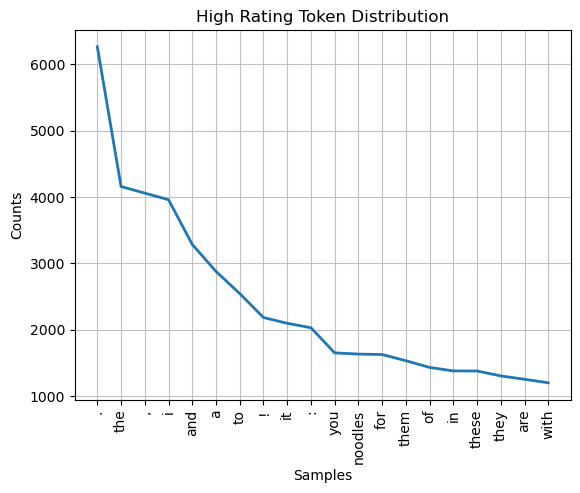

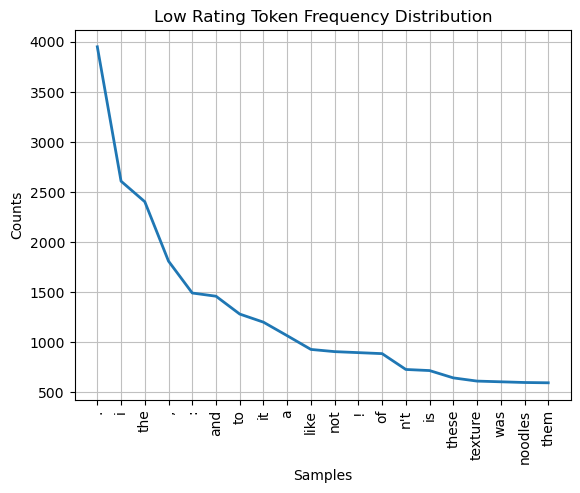

In [25]:
## Instantiate high frequency distribution
high_freq_dist = FreqDist(high_words)
low_freq_dist = FreqDist(low_words)

## Plot the distribution
high_freq_dist.plot(20, title='High Rating Token Distribution')

low_freq_dist.plot(20, title='Low Rating Token Frequency Distribution');

We can see already that punctuation and very common words are at the top of both lists.  To avoid this, we can use our normalized data instead.  Let's use our lemmas!

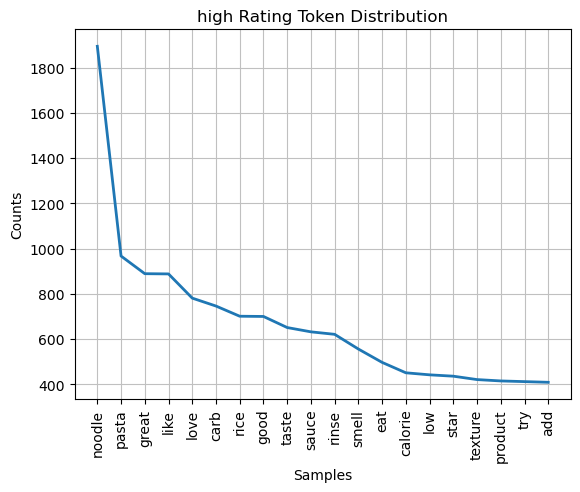

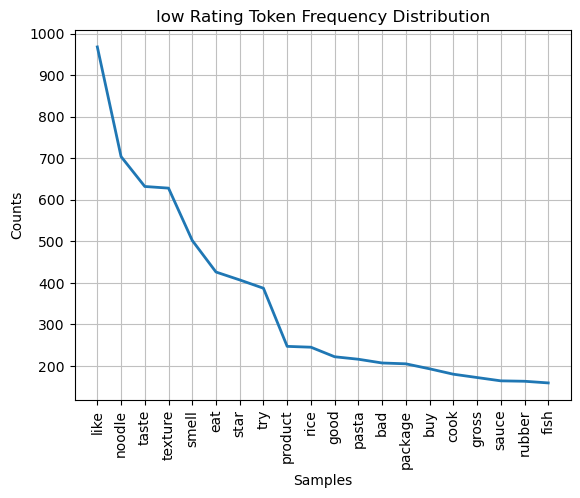

In [34]:
## Create list of all tokens in all documents
high_words = high['spacy_lemmas'].explode().fillna('').to_list()
low_words = low['spacy_lemmas'].explode().fillna('').to_list()

## Instantiate high frequency distribution
high_freq_dist = FreqDist(high_words)
low_freq_dist = FreqDist(low_words)

## Plot the distribution
high_freq_dist.plot(20, title='high Rating Token Distribution')

low_freq_dist.plot(20, title='low Rating Token Frequency Distribution');

These are more informative!  We see words like 'good', 'love', 'hope', 'great', and 'nice' in the highs and 'miss', 'work', 'sad', 'bad', and 'hate' in lows.

While this may not be surprising with high and low sentiments, if we were classifying other kinds of text, like spam emails or patent applications, it could be very enlightening!

# Word Clouds

Word Clouds tell us the same kinds of things as a frequency distribution, but are a nice way to visualize.  They can be used for project headers or presentations.

The `WordCloud` class expects texts to be one long string, so.  We will use our lemmas again, so we have to join all the tokens for each document into one long string.

## Processing the data for WordCloud

WordCloud expects one single string of all the words in a corpus.  since we already have a list of all the words, for each sentiment, we can just join those.

In [35]:
## Join the original text for each group
high_text_joined = " ".join(high['text'])
low_text_joined = " ".join(low['text'])

## Creating and displaying the Word Clouds

We will create the clouds and generate the images below.  We want to focus on larger words, otherwise we get some strange results due to contractions.  We will tell WordCloud to only generate words with 2 or more letters.

### Using the Original Text

Let's start with using the raw text to make the wordlcouds.

In [36]:

def plot_wordclouds(high_cloud, low_cloud, title='Comparing Word Usage'):
    """Plots the wordlcouds for our two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].imshow(high_cloud)
    axes[0].set_title('High Ratings')
    axes[0].axis('off')
    
    axes[1].imshow(low_cloud)
    axes[1].set_title('Low Ratings')
    axes[1].axis('off')
    fig.tight_layout()
    
    fig.suptitle(title,y=1.0, fontsize='xx-large');
    return fig


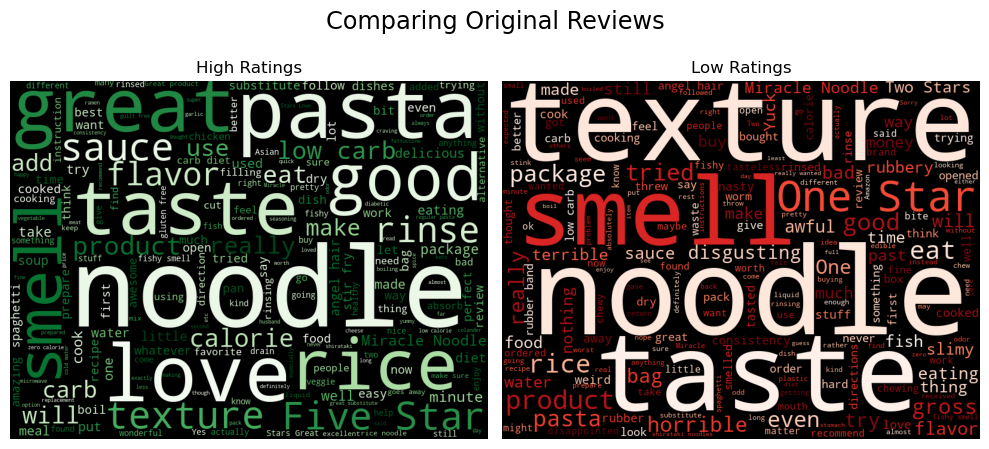

In [37]:
## Generate the WordCloud Images
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_text_joined)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(low_text_joined)

fig = plot_wordclouds(high_cloud, low_cloud, title="Comparing Original Reviews")

# Saving figure for README
fig.savefig('images/wordclouds-original-reviews.png', dpi=300, bbox_inches='tight', transparent=False)

> Consider what words should be considered stopwords **just for EDA**

In [82]:
from wordcloud import STOPWORDS

In [83]:
# Add more custom stopwords for EDA
custom_stopwords = [*STOPWORDS,'noodle','one','two','five','star']

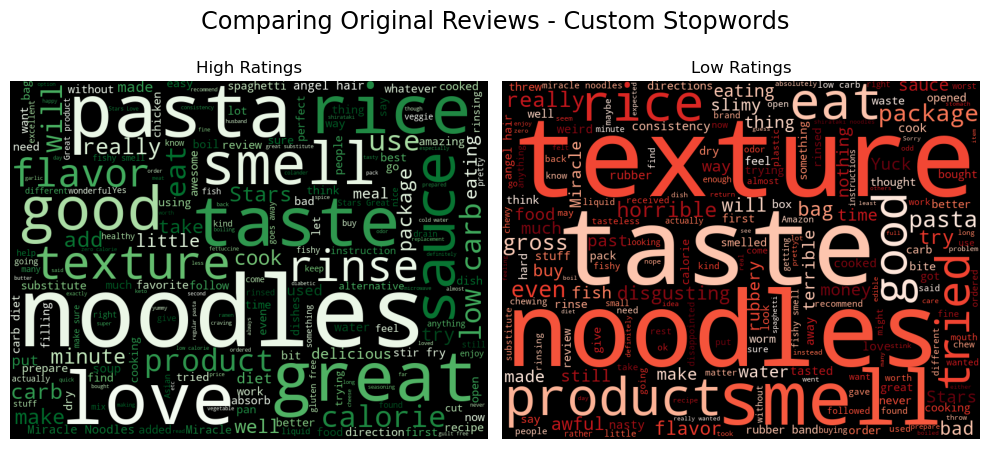

In [84]:
## Generate the WordCloud Images using the custom stopwords
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42,
                     stopwords=custom_stopwords)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_text_joined)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(low_text_joined)

# ## Plot the Images
fig =  plot_wordclouds(high_cloud,low_cloud, title="Comparing Original Reviews - Custom Stopwords")

# Save figure
fig.savefig('images/wordclouds-original-reviews-custom-stop.png', dpi=300,transparent=False, bbox_inches='tight')

### Using Lemmas

Depending on the corpus, visualizing lemmas may provide a clearer view of the data.

In [85]:
## Join the words for each sentiment
all_high_lemmas = ' '.join(high_words)
all_low_lemmas = ' '.join(low_words)
type(all_high_lemmas)

str

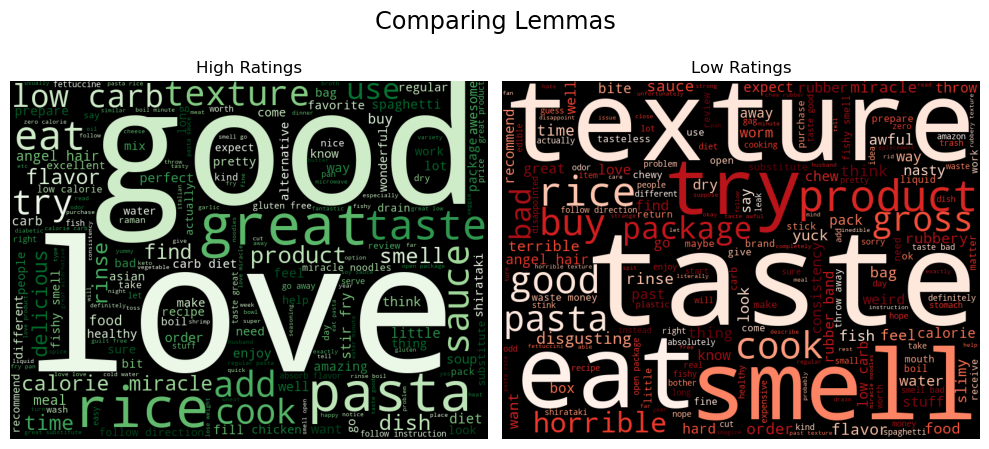

In [86]:
## Generate the WordCloud Images
# wordcloud_kws = dict(min_word_length=2,width=800, height=600, )
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(all_high_lemmas)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(all_low_lemmas)

## Plot the Images
fig = plot_wordclouds(high_cloud, low_cloud, title='Comparing Lemmas')


This can be a fun way to help you stakeholders get a feel for the token distributions in our data. However, its hard to truly quantify the things that customers did or did not like.

# N-gram Analysis

We can do something similar with ngrams.  NLTK has native classes for finding and measuring the frequency of ngrams as well.

For this we need 2 objects: a measures class depending on the measure we want to see and a finder class based on the number of words in our ngram.

These classes exist for bi, tri, and quadgrams, we will start with bigrams.

## Calcuate Frequency Scores

In [87]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

## Create measure classes
measures = BigramAssocMeasures()

## Create collector classes
high_finder = BigramCollocationFinder.from_words(high_words)
low_finder = BigramCollocationFinder.from_words(low_words)

In [88]:
## Calculate high-rating ngram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)

# Save as a dataframe
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])


## Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])

## Display the frequency scores
display(high_ngram_scores_df.head(20),low_ngram_scores_df.head(20))

,high ngram,high score
0,"(low, carb)",0.006091
1,"(angel, hair)",0.003348
2,"(miracle, noodle)",0.003328
3,"(stir, fry)",0.003066
4,"(taste, like)",0.002521
5,"(love, noodle)",0.002340
6,"(carb, diet)",0.002017
7,"(fishy, smell)",0.001876
8,"(star, great)",0.001654
9,"(rice, noodle)",0.001634


,low ngram,low score
0,"(taste, like)",0.005942
1,"(smell, like)",0.004111
2,"(like, eat)",0.003460
3,"(miracle, noodle)",0.002849
4,"(texture, like)",0.002768
5,"(rubber, band)",0.002727
6,"(angel, hair)",0.002483
7,"(like, fish)",0.002361
8,"(low, carb)",0.002239
9,"(waste, money)",0.002116


## Plot Frequency Scores

In [89]:
top_20_ngrams_high = high_ngram_scores_df.set_index("high ngram").head(20)
top_20_ngrams_high

,high score
high ngram,
"(low, carb)",0.006091
"(angel, hair)",0.003348
"(miracle, noodle)",0.003328
"(stir, fry)",0.003066
"(taste, like)",0.002521
"(love, noodle)",0.002340
"(carb, diet)",0.002017
"(fishy, smell)",0.001876
"(star, great)",0.001654


In [90]:
top_20_ngrams_low = low_ngram_scores_df.set_index("low ngram").head(20)
top_20_ngrams_low

,low score
low ngram,
"(taste, like)",0.005942
"(smell, like)",0.004111
"(like, eat)",0.003460
"(miracle, noodle)",0.002849
"(texture, like)",0.002768
"(rubber, band)",0.002727
"(angel, hair)",0.002483
"(like, fish)",0.002361
"(low, carb)",0.002239


### Visualizing ngram frequency

In [91]:
top_20_ngrams_high["high score"]

high ngram
(low, carb)              0.006091
(angel, hair)            0.003348
(miracle, noodle)        0.003328
(stir, fry)              0.003066
(taste, like)            0.002521
(love, noodle)           0.002340
(carb, diet)             0.002017
(fishy, smell)           0.001876
(star, great)            0.001654
(rice, noodle)           0.001634
(follow, direction)      0.001614
(low, calorie)           0.001452
(miracle, noodles)       0.001412
(gluten, free)           0.001392
(follow, instruction)    0.001331
(great, product)         0.001311
(go, away)               0.001291
(star, love)             0.001291
(noodle, great)          0.001271
(taste, great)           0.001230
Name: high score, dtype: float64

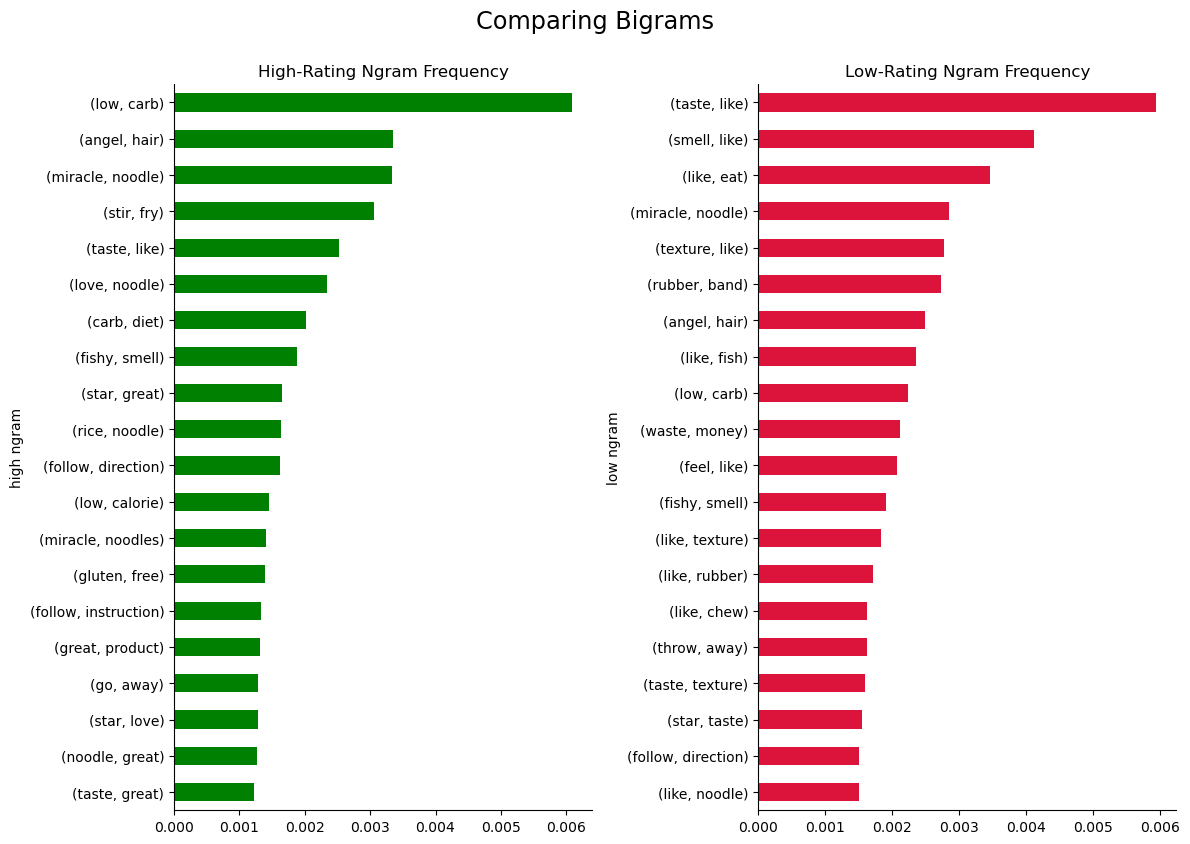

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 8))
## Plot the ngram frequencies
top_20_ngrams_high["high score"].sort_values().plot(
    kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
)

top_20_ngrams_low["low score"].sort_values().plot(
    kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
)
# Remove lines from top and right edges (spines)
for ax in axes:
    ax.spines["top"].set_visible(False)  # Remove the top spine
    ax.spines["right"].set_visible(False)  # Remove the right spine

fig.tight_layout()
fig.suptitle("Comparing Bigrams", y=1.05, fontsize="xx-large");

In [93]:
def plot_group_ngrams( low_ngram_scores, high_ngram_scores, 
                       plot_col_low="low score",top_n=20,
                      plot_col_high="high score",figsize=(12, 8),):
    # Get top n ngrams for both groups (set index for easier pandas plotting)
    top_n_ngrams_high = high_ngram_scores.set_index("high ngram").head(top_n)
    top_n_ngrams_low = low_ngram_scores.set_index("low ngram").head(top_n)

    ## Plot the ngram frequencies
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    #
    top_n_ngrams_high[plot_col_high].sort_values().plot(
        kind="barh", title="High-Rating Ngram Frequency", ax=axes[0], color="green"
    )

    top_n_ngrams_low[plot_col_low].sort_values().plot(
        kind="barh", title="Low-Rating Ngram Frequency", color="crimson", ax=axes[1]
    )
    for ax in axes:
        ax.spines["top"].set_visible(False)  # Remove the top spine
        ax.spines["right"].set_visible(False)  # Remove the right spine

    fig.tight_layout()
    return fig

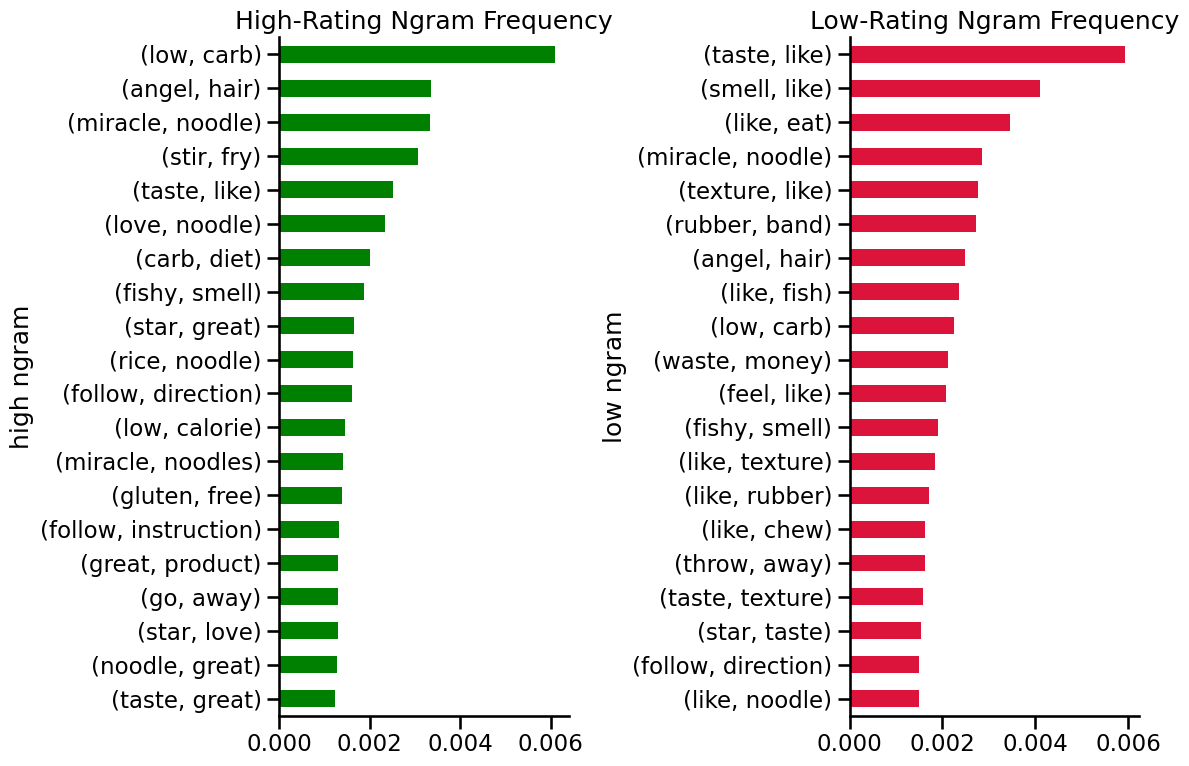

In [94]:
with sns.plotting_context('talk'):
    fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

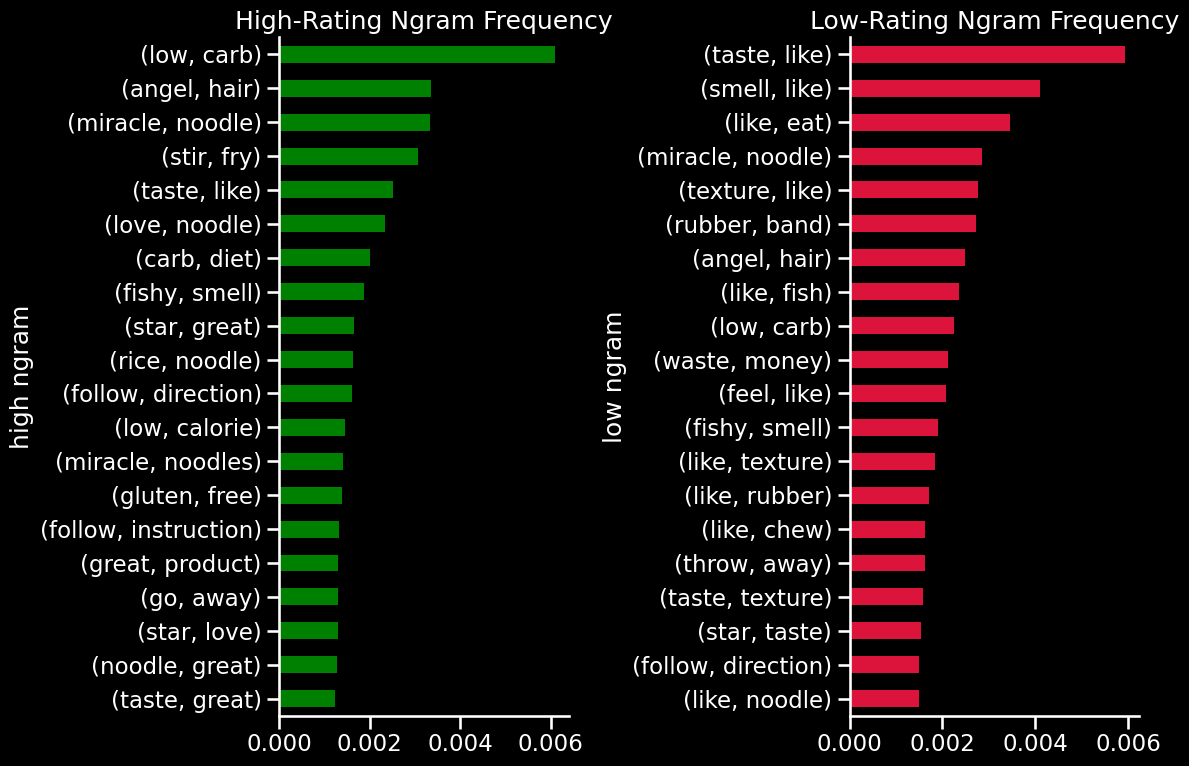

In [95]:
with plt.style.context(['dark_background',]):
    with sns.plotting_context("talk"):
        fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

This might be more enlightening than the individual word frequency counts.  There are some relatable bigrams here.

We are also seeing a lot of versions of 'happy mother's day' which may tell us that more normalization is required here.  This would be a consideration in longer term projects.

### Trigrams

In [96]:
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

## Create measure classes
measures = TrigramAssocMeasures()

## Create collector classes
high_finder = TrigramCollocationFinder.from_words(high_words)
low_finder = TrigramCollocationFinder.from_words(low_words)

In [97]:
## Calculate high-rating trigram scores
high_ngram_scores = high_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['high ngram', 'high score'])



## Calculate low-rating ngram scores
low_ngram_scores = low_finder.score_ngrams(measures.raw_freq)
# Save as a dataframe
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['low ngram', 'low score'])


## Display the frequency scores
display(high_ngram_scores_df.head(20),low_ngram_scores_df.head(20))

,high ngram,high score
0,"(low, carb, diet)",0.001755
1,"(great, low, carb)",0.000807
2,"(smell, go, away)",0.000666
3,"(rinse, cold, water)",0.000585
4,"(love, miracle, noodle)",0.000484
5,"(angel, hair, noodle)",0.000464
6,"(noodle, love, noodle)",0.000424
7,"(angel, hair, pasta)",0.000383
8,"(love, noodle, love)",0.000363
9,"(star, great, product)",0.000363


,low ngram,low score
0,"(smell, like, fish)",0.001913
1,"(like, chew, rubber)",0.000692
2,"(taste, like, rubber)",0.000692
3,"(chew, rubber, band)",0.000651
4,"(feel, like, eat)",0.000529
5,"(like, eat, rubber)",0.000529
6,"(texture, like, rubber)",0.000529
7,"(taste, like, eat)",0.000488
8,"(like, dead, fish)",0.000407
9,"(star, taste, like)",0.000407


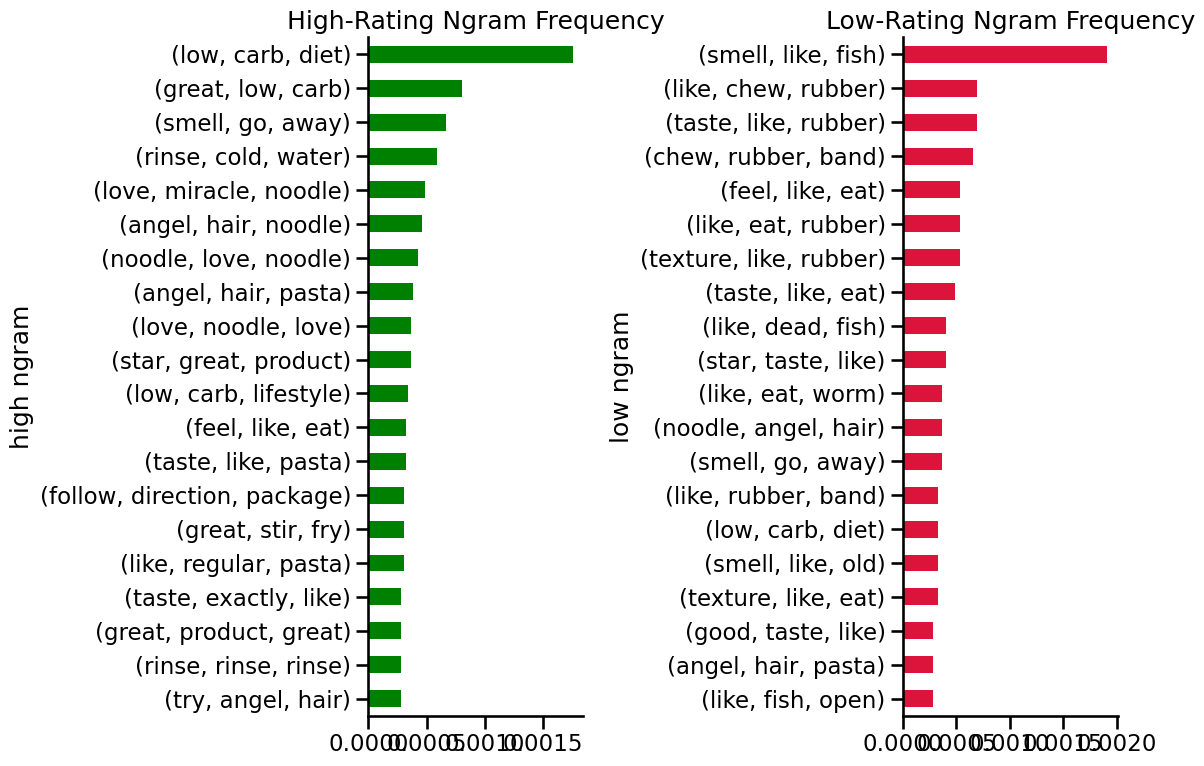

In [98]:
# with plt.style.context(['ggplot','dark_background',]):
with sns.plotting_context('talk'):

    fig = plot_group_ngrams(low_ngram_scores_df, high_ngram_scores_df)

# Preparing Data for Modeling

In this lesson we will be using a Bag of Words approach to modeling.  This means our final features will be just the counts of how many times each word appears in each document.  

We have many versions of our data to choose from for modeling.  Our lemmas are probably the most normalized, but our raw tokens have the most information.  The others are somewhere in between.  In this notebook we will be using the lemmatized data.  

We will try both the CountVectorizer and TfidfVectorizer for vectorization.  Both create a column for every word in the vocabulary.

**CountVectorizer** adds the raw counts of each word for each document.  It can be very sensitive to stop words, so we want to be sure to 

**TfidifVectorizer** adds a value that represents how unique the word is to the document, compared to all other documents in the corpus.  The more times a word appears in a document and the fewer times it appears in other documents the higher the value will be for that word.

Both of these vectorizers assume that documents will be single strings.  We will join our lemmas together again.

In [99]:
## Import Modeling Package
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [100]:

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

### Train Test Split
We created null values in our target column, so we will drop the null values from the rating column before making our X and y data.

In [101]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating'])
df_ml.isna().sum()

asin                 0
reviewerID           0
overall              0
year                 0
category             0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
bigrams              0
rating               0
dtype: int64

In [102]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1                                                                                                                                                                                                                                   Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck
2                                                                                                                                                                                                                                                                                One Star: MOM DID NOT LIKE THESE
3               The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol or claim that the online description shows.
5                                                                                 

In [103]:
y.value_counts(normalize=True)

high    0.565204
low     0.434796
Name: rating, dtype: float64

### Validation Split

We will perform a triple split.  That way we can tune our model to a validation set and test the final version on a test set.  This avoid tuning our model to specifically perform well on just one set of testing data and gives us a better idea of how our model will perform on new data.

In [104]:
# ## Split data into train, test, val
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# len(X_train_full)

- Using 70% of data as train, 15% as test and 15 % as val (will use in deep nlp codealongs next class)

In [105]:
## Split data into train, test, val
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)
(len(X_train_full), len(X_val), len(X_test))

(2313, 496, 496)

In [106]:
# Check class balance
y_train_full.value_counts(normalize=True)

high    0.565067
low     0.434933
Name: rating, dtype: float64

### Under-Sampling Majority Group

We have a very imbalanced dataset. We will take a small sample from the majority class to match the number of reviews for the minority group.

In [107]:
from imblearn.under_sampling import RandomUnderSampler

In [108]:
X_train_full#.values.reshape(-1,1)

4229    EXCELLENT 0SP WW SUBSTITUTE: These are amazing! I am on weight watchers and these are 0sp! The taste is not good nor bad. I found they were tasteless, but really beef up a dish. It is especially helpful to have the mindset that I am eating carbs. I will continue to buy these for the convenience;...
3075    I found the texture too much like tapioca pearls for my personal preference: These really truly don't have any flavor if you rinse them enough, however, I found the texture too much like tapioca pearls for my personal preference.  Would recommend anyone looking for a good pasta or rice substitut...
3260                                                                                                                            Tasteless: These have no flavor.  They are a waste of space.  They have not nutritional value.  I prefer to make zucchini noodles or kelp noodles for when I craving a noodle dish.
2235                                                                        

In [109]:
# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),y_train_full)

# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()

# Check for class balance
y_train.value_counts()

high    1006
low     1006
Name: rating, dtype: int64

## Modeling

We are going to use a Multinomial Naive Bayes model.  Bayesian models have been shown to often perform well with text data.  However, we could use any classification model we wanted to.

We will be using a **Bag of Words** approach to classififying this text.  It's called **Bag of Words** because it's like we just put the words for each document into a bag.  We will not respect the order of the words, only which words are in the text and how many times they appear.  The models will use the frequency of each word in each text to classify it.

## Data Preparation: Vectorization

We have texts that are variable in length, but our sklearn models require a standard input size.  How do we make this transformation?

Then answer is Vectorization!

We will be using 2 different forms of vectorization: Count Vectorization and TF-IDF Vectoriation

## Count Vectorization

This form of vectorization is the easier one to understand.  We will use the vocabulary of all unique token found in our training data and create a column for each one.  As you can image, this can be a lot of columns!  This is one reason that we want to normalize data and remove stop words.

We've already lemmatized our data and removed stop words, but if we hadn't CountVectorizer could do that for us.  It can also create ngrams, strip accent marks, and more.  

One new feature we will use is `min_df`.  This will remove words that only appear a few times.  Remember that models need many examples of feature values in order to find patterns.  Tokens that only appear once or twice in the data will not be useful for our models to learn from.  Removing them will further normalize the data and reduce the number of features.

We will also try including bigrams in our columns.  We can tell the vectorizer the range of ngrams to use with `ngram_range=`.  It takes a tuple of a lower and upper bound of ngrams.  For example, if we wanted unigrams (one token), bigrams, and trigrams, we would set `ngrame_range=(1,3)`.  In this case we will just use unigrams and bigrams.

[Here is the documention for CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to learn more

In [110]:
## Instantiate CountVectorizer
countvector = CountVectorizer()#min_df=3, ngram_range=(1,2))
countvector.fit(X_train)

# Transform X_train to see the result (for demo only)
countvector.transform(X_train)

<2012x4718 sparse matrix of type '<class 'numpy.int64'>'
	with 67203 stored elements in Compressed Sparse Row format>

In [111]:
len(countvector.vocabulary_)

4718

It would be great to examine the resulting data, but as you can see it's saved as a **sparse matrix**.  We can also see that there are over 100 thousand columns, so they would be difficult to explore.

A **Sparse Matrix** is a compressed form of a numpy array.  It sqeezes out all of the 0 values to save space.  Otherwise our vectorized dataset would be very large!!

## Model Pipeline

Like other transformers, sklearn Vectorizers can be used in pipelines with models.  We will create a pipeline with our vectorizer and our Naive Bayes model.

In [112]:
## Create a model pipeline for inference.
nbayes = MultinomialNB()

count_pipe = Pipeline([('vectorizer', countvector), 
                       ('naivebayes', nbayes)])

count_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('naivebayes', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.96      0.98      0.97      1006
         low       0.98      0.96      0.97      1006

    accuracy                           0.97      2012
   macro avg       0.97      0.97      0.97      2012
weighted avg       0.97      0.97      0.97      2012



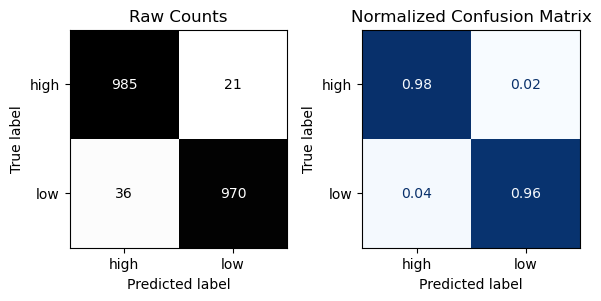


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.95      0.95      0.95       288
         low       0.94      0.93      0.93       208

    accuracy                           0.94       496
   macro avg       0.94      0.94      0.94       496
weighted avg       0.94      0.94      0.94       496



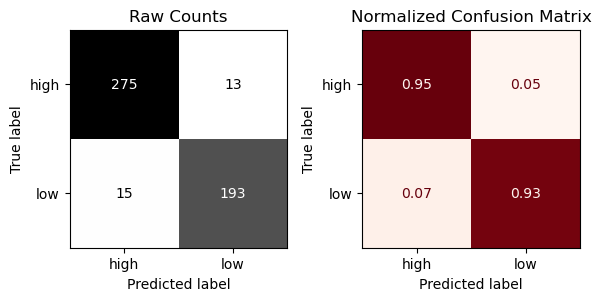

In [113]:
evaluate_classification(count_pipe, X_train, y_train, X_test, y_test)

Our model was 95% accurate, but did not seem overly biased against any given class.  There might be a slight bias toward the neutral class.

## TF-IDF Vectorization

Another popular **Bag of Words** vectorization strategy is TF-IDF vectorization.  In this stragegy, rather than just counting each word, we compare the frequency of a word in a document with the frequency of that word in other documents.  This measures the specificity of the word.

If a word is common in a document, but rare in the corpus as a whole, it gets a higher value.  If it's common throughout the corpus, it gets a lower value.  This helps TF-IDF vectorized data to resist the effects of common stop words or other words that tend to be common in that particular corpus.  They will have a lesser effect on the prediction.

[TfidfVectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [114]:
## Instantiate TF-IDF Vectorizor
tfidf = TfidfVectorizer()#min_df=3, ngram_range=(1,2))

tfidfbayes = MultinomialNB()

tfidf_pipe = Pipeline([('vectorizer', tfidf),
                       ('bayes_model', tfidfbayes)])

tfidf_pipe.fit(X_train, y_train)

                      

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('bayes_model', MultinomialNB())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.95      0.99      0.97      1006
         low       0.99      0.95      0.97      1006

    accuracy                           0.97      2012
   macro avg       0.97      0.97      0.97      2012
weighted avg       0.97      0.97      0.97      2012



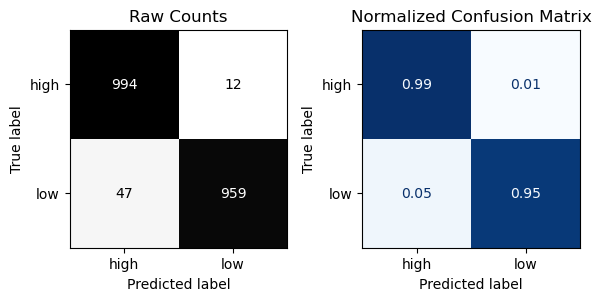


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.94      0.97      0.95       288
         low       0.95      0.92      0.93       208

    accuracy                           0.95       496
   macro avg       0.95      0.94      0.94       496
weighted avg       0.95      0.95      0.95       496



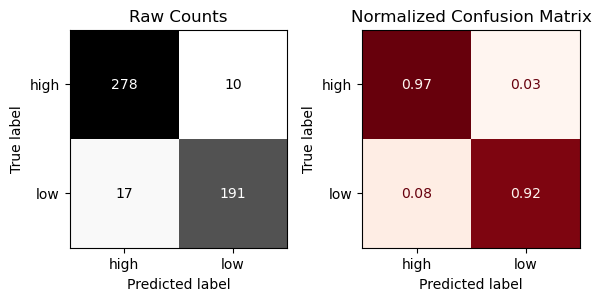

In [115]:
evaluate_classification(tfidf_pipe, X_train, y_train, X_test, y_test)

# Conclusion

There are a lot of choices in how to prepare data for text classification:
* Remove stop words and punctuation?
* Lemmatize?  Stem?
* How to Vectorize?
* ngrams?

## Challenge:

Try improving the score.  Ideas to try:
* Try a different version of the data: non-lemmatized data, include stop words, different range of n_grams
* Tune the vectorizer: Increase the min_df, decrease the max_df, other options: [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
* Tune the model: [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
* Try a different model: Can use any classification model for this.
* Consider PCA
* Be sure to evaluate each of your models only on the X_val/y_val
* Evaluate your best model on the holdout X_test/y_test

# (Bonus/Optional) GridSearch Text Preprocessing Params

We can tune our text preprocessing choices using gridsearch.

In [116]:
gs_pipe = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',MultinomialNB())])
gs_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()), ('clf', MultinomialNB())],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': MultinomialNB(),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'clf__force_alpha': 'warn'}

In [117]:
# Define params to try for both vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english']
}

# Setting params for the count vectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}


# Setting params for tfidf vectorizer 
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

# combine into list of params
params_combined = [param_grid_count, param_grid_tfidf]
params_combined

[{'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']},
 {'vectorizer': [TfidfVectorizer()],
  'vectorizer__norm': ['l1', 'l2'],
  'vectorizer__use_idf': [True, False],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english']}]

In [118]:
%%time
# Create grid search
grid_search = GridSearchCV(gs_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 748 ms, sys: 208 ms, total: 956 ms
Wall time: 3.98 s


{'vectorizer': CountVectorizer(max_df=0.7, min_df=2),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.96      0.98      0.97      1006
         low       0.97      0.96      0.97      1006

    accuracy                           0.97      2012
   macro avg       0.97      0.97      0.97      2012
weighted avg       0.97      0.97      0.97      2012



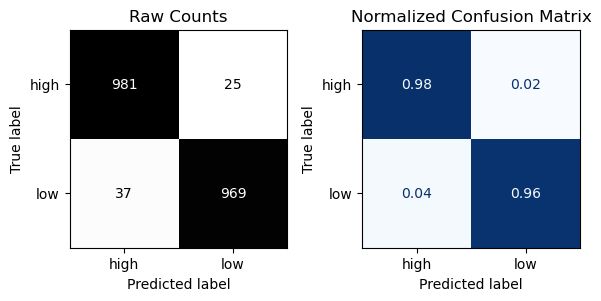


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.96      0.94      0.95       288
         low       0.92      0.94      0.93       208

    accuracy                           0.94       496
   macro avg       0.94      0.94      0.94       496
weighted avg       0.94      0.94      0.94       496



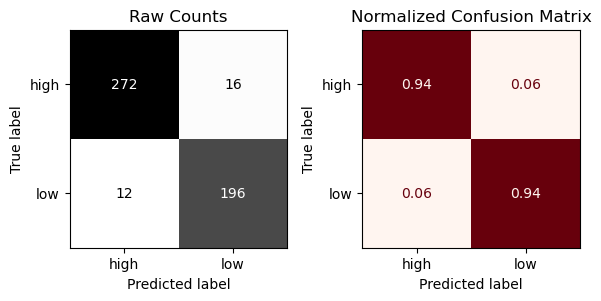

In [119]:
best_gs_pipe = grid_search.best_estimator_
evaluate_classification(best_gs_pipe, X_train, y_train, X_test, y_test)

### RandomForest

In [120]:
rf_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',RandomForestClassifier(class_weight='balanced'))])
rf_pipe.get_params()

{'memory': None,
 'steps': [('vectorizer', CountVectorizer()),
  ('clf', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'vectorizer': CountVectorizer(),
 'clf': RandomForestClassifier(class_weight='balanced'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': None,
 'vectorizer__vocabulary': None,
 'clf__bootstrap': True,
 'clf__ccp_alpha': 0.0,
 'clf__class_weight': 'balanced',
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'sqrt',
 'clf__max_leaf_node

In [121]:
%%time
# Create grid search
grid_search = GridSearchCV(rf_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 2.15 s, sys: 435 ms, total: 2.59 s
Wall time: 22.6 s


{'vectorizer': CountVectorizer(max_df=0.7, min_df=3),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__stop_words': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       1.00      1.00      1.00      1006
         low       1.00      1.00      1.00      1006

    accuracy                           1.00      2012
   macro avg       1.00      1.00      1.00      2012
weighted avg       1.00      1.00      1.00      2012



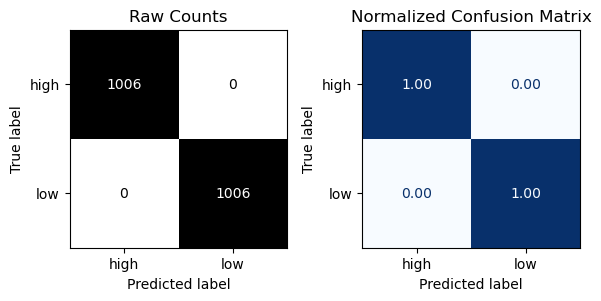


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.94      0.95      0.95       288
         low       0.94      0.91      0.92       208

    accuracy                           0.94       496
   macro avg       0.94      0.93      0.93       496
weighted avg       0.94      0.94      0.94       496



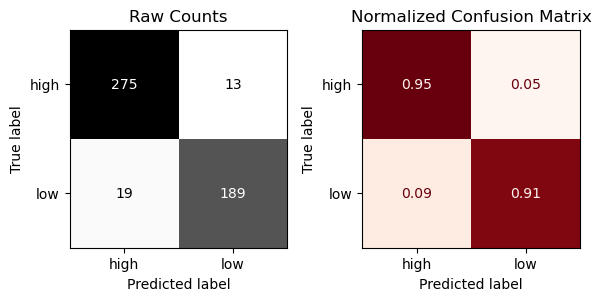

In [122]:
best_rf_pipe = grid_search.best_estimator_
evaluate_classification(best_rf_pipe, X_train, y_train, X_test, y_test)

### LogReg

In [123]:
logreg_pipe  = Pipeline([('vectorizer',CountVectorizer()),
                    ('clf',LogisticRegression(max_iter=500, class_weight='balanced'))])
# logreg_pipe.get_params()

In [124]:
%%time
# Create grid search
grid_search = GridSearchCV(logreg_pipe, params_combined, cv=3, verbose=1, n_jobs=-1)
    
    
# Fit the model
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 270 candidates, totalling 810 fits
CPU times: user 792 ms, sys: 199 ms, total: 991 ms
Wall time: 4.86 s


{'vectorizer': TfidfVectorizer(max_df=0.7, min_df=2),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 2,
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.97      0.97      0.97      1006
         low       0.97      0.97      0.97      1006

    accuracy                           0.97      2012
   macro avg       0.97      0.97      0.97      2012
weighted avg       0.97      0.97      0.97      2012



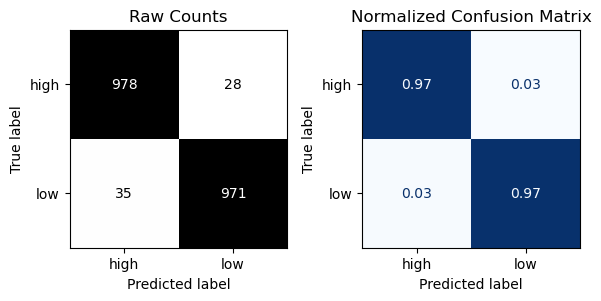


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        high       0.97      0.95      0.96       288
         low       0.93      0.96      0.95       208

    accuracy                           0.95       496
   macro avg       0.95      0.95      0.95       496
weighted avg       0.95      0.95      0.95       496



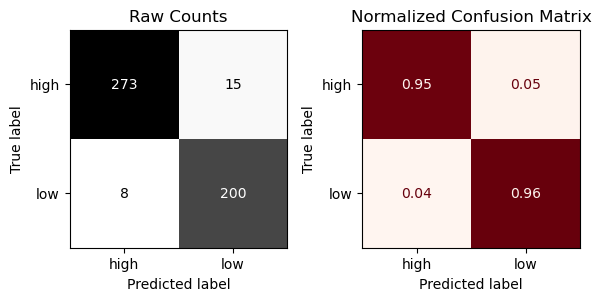

In [125]:
best_logreg_pipe = grid_search.best_estimator_
evaluate_classification(best_logreg_pipe, X_train, y_train, X_test, y_test)